In [41]:
import pandas as pd

locs_df = pd.read_csv("data/simulated_data_spcap.csv")

In [42]:
import jax
import jax.numpy as jnp

locs = jnp.asarray(locs_df.values[:, 0:3], dtype=jnp.float32)
stddev = jnp.asarray(locs_df.values[0, 3], dtype=jnp.float32)
half_tau  = (stddev ** -2) / 2.0
log_const = -0.5 * jnp.log(stddev**2 * 2.0 * jnp.pi)

In [43]:
import locmofitpy2

# keys = jax.random.split(key, 9)  # 8 params + next key
# key = keys[0]
# k = keys[1:]

# params = {
#     "x": jax.random.uniform(k[0], (), dtype=jnp.float32),
#     "y": jax.random.uniform(k[1], (), dtype=jnp.float32),
#     "z": jax.random.uniform(k[2], (), dtype=jnp.float32),
#     "c": jax.random.uniform(k[3], (), dtype=jnp.float32),
#     "vartheta": jax.random.uniform(k[4], (), dtype=jnp.float32),
#     "phi0": jax.random.uniform(k[5], (), dtype=jnp.float32),
#     "theta": jax.random.uniform(k[6], (), dtype=jnp.float32),
#     "phi": jax.random.uniform(k[7], (), dtype=jnp.float32),
# }

key = jax.random.PRNGKey(1)
sc = locmofitpy2.SphericalCap.init(key)

In [44]:
# params["x"].size

In [45]:
# def circle_points(vphi:Array, r:Array, phi0:Array) -> Array:
#     angles = vphi + phi0
#     x = r * jnp.cos(angles)
#     y = r * jnp.sin(angles)
#     z = jnp.zeros_like(x)
#     return jnp.stack([x, y, z], axis=1)

In [46]:
# import locmofitpy2

# def forward_model(vphi, x, y, z, r, phi0, theta, phi, delta_z):
#     X0 = circle_points(vphi, r, phi0)
#     X1 = X0 + jnp.array([0.0, 0.0, 1.0], X0.dtype) * delta_z
#     X  = jnp.concatenate([X0, X1], axis=0)
#     ax = -jnp.sin(phi)
#     ay =  jnp.cos(phi)
#     az = jnp.array(0.0, dtype=X.dtype)
#     R = locmofitpy2.rodrigues(ax, ay, az, theta) 
#     Y = X @ R.T                                       # (2N, 3)
#     t = jnp.stack([x, y, z])                          # (3,)
#     Y = Y + t 
#     return Y

In [47]:
import equinox as eqx

train = {
    "x": True,
    "y": True,
    "z": True,
    "c": False,
    "vartheta": False,
    "phi0": False,
    "theta": True,
    "phi": True,
}

# def mask_sphericalcap(model):
#     # Build a PyTree of booleans matching the model's leaves (True => update)
#     # Non-array leaves (static buffers) will be ignored by eqx.filter anyway.
#     return eqx.tree_map(
#         lambda leaf, name=None: True,  # placeholder, we'll set explicitly below
#         eqx.filter(model, eqx.is_array),
#     )

trainable0 = eqx.filter(sc, eqx.is_array)
static0    = eqx.filter(sc, lambda x: not eqx.is_array(x)) # buffers/static fields

mask = {
    "x": True,
    "y": True,
    "z": True,
    "c": True,
    "vartheta": True,
    "phi0": True,
    "theta": True,
    "phi": True,
}

In [48]:
def fun(trainable):
    m = eqx.combine(trainable, static0)  # rebuild full model
    positions = m()  # (N,3)
    return locmofitpy2.negative_log_likelihood_jit(locs, positions, half_tau, log_const)

In [49]:
import optax

optimizer = optax.lbfgs()
opt_state = optimizer.init(trainable0)

value_and_grad_fun = optax.value_and_grad_from_state(fun)


@jax.jit
def solve_lbfgs(trainable, opt_state, max_iter=50, tol=1e-6):
    def step(carry):
        trainable, state = carry
        value, grad = value_and_grad_fun(trainable, state=state)
        updates, state = optimizer.update(
            grad, state, trainable, value=value, grad=grad, value_fn=fun
        )
        trainable = optax.apply_updates(trainable, updates)
        return trainable, state

    def cond(carry):
        _, state = carry
        k = optax.tree.get(state, "count")
        g = optax.tree.get(state, "grad")
        return (k == 0) | ((k < max_iter) & (optax.tree.norm(g) >= tol))

    return jax.lax.while_loop(cond, step, (trainable, opt_state))


In [50]:
# %%timeit
trainable_opt, opt_state = solve_lbfgs(trainable0, opt_state, max_iter=200, tol=1e-6)

model_opt = eqx.combine(trainable_opt, static0)
final_loss = fun(trainable_opt)
final_loss.block_until_ready()

ValueError: Exception raised while checking equality of metadata fields of pytree. Make sure that metadata fields are hashable and have simple equality semantics. (Note: arrays cannot be passed as metadata fields!)

In [ ]:
print(
    float(sc.x),
    float(sc.y),
    float(sc.z),
    float(sc.c),
    float(sc.vartheta),
    float(sc.phi0),
    float(sc.theta),
    float(sc.phi),
)

0.5319373607635498 -0.24392002820968628 0.1453534960746765 0.15561234951019287 0.6733381748199463 0.04619324207305908 0.7928290367126465 0.7874472141265869


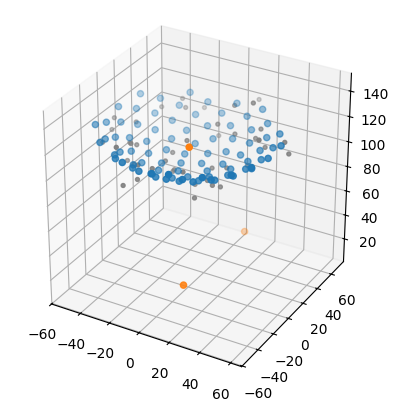

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ground_truth = pd.read_csv("data/ground_truth_spcap.csv")

positions = model_opt()

# If running on GPU/TPU, ensure compute finished before transferring for plotting
positions.block_until_ready()

positions_np = np.array(positions)  # converts JAX array -> NumPy array on host

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.set_box_aspect((1, 1, 1))
ax.scatter(locs_df["x"], locs_df["y"], locs_df["z"], c="gray", s=8)  # type: ignore[arg-type]
ax.scatter(ground_truth["x"], ground_truth["y"], ground_truth["z"])  # type: ignore[arg-type]
ax.scatter(positions_np[:, 0], positions_np[:, 1], positions_np[:, 2])  # type: ignore[arg-type]

plt.show()
